This notebook is based on the file [Feature crosses programming exercise](https://colab.research.google.com/notebooks/mlcc/feature_crosses.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=featurecrosses-colab&hl=en), which is part of Google's [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Crosses

**Learning Objectives:**
  * Improve a linear regression model with the addition of additional synthetic features (this is a continuation of the previous exercise)
  * Use an input function to convert  `DataFrame` objects to feature columns
  * Use the Adam optimization algorithm for model training
  * Create new synthetic features through one-hot encoding, binning, and feature crosses

## Setup

First, as we've done in previous exercises, let's define the input and create the data-loading code.

In [2]:
using Plots
gr(fmt=:png)
using DataFrames
using TensorFlow
import CSV
import StatsBase
using Random
using Statistics

sess=Session()
california_housing_dataframe = CSV.read("california_housing_train.csv", delim=",");
california_housing_dataframe = california_housing_dataframe[shuffle(1:size(california_housing_dataframe, 1)),:];

2019-02-24 14:12:38.860817: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


In [3]:
function preprocess_features(california_housing_dataframe)
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    [:latitude,
     :longitude,
     :housing_median_age,
     #:total_rooms,
     #:total_bedrooms,
     #:population,
     :households,
     :median_income]]
  processed_features = selected_features
  # Create a synthetic feature.
  processed_features[:rooms_per_person] = (
    california_housing_dataframe[:total_rooms] ./
    california_housing_dataframe[:population])
  return processed_features
end
    
function preprocess_targets(california_housing_dataframe)
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets[:median_house_value] = (
    california_housing_dataframe[:median_house_value] ./ 1000.0)
  return output_targets
end

preprocess_targets (generic function with 1 method)

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(first(california_housing_dataframe,12000))
training_targets = preprocess_targets(first(california_housing_dataframe,12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(last(california_housing_dataframe,5000))
validation_targets = preprocess_targets(last(california_housing_dataframe,5000))

# Double-check that we've done the right thing.
println("Training examples summary:")
describe(training_examples)
println("Validation examples summary:")
describe(validation_examples)

println("Training targets summary:")
describe(training_targets)
println("Validation targets summary:")
describe(validation_targets)

Training examples summary:
Validation examples summary:
Training targets summary:
Validation targets summary:


,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,median_house_value,209.163,14.999,181.95,500.001,,,Float64


In [5]:
function construct_feature_columns(input_features)
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  out=convert(Matrix, input_features[:,:])
  return convert(Matrix{Float64},out) 
end

construct_feature_columns (generic function with 1 method)

In [6]:
function create_batches(features, targets, steps, batch_size=5, num_epochs=0)
  """Create batches.

  Args:
    features: Input features.
    targets: Target column.
    steps: Number of steps.
    batch_size: Batch size.
    num_epochs: Number of epochs, 0 will let TF automatically calculate the correct number
  Returns:
    An extended set of feature and target columns from which batches can be extracted.
  """     
    if(num_epochs==0)
        num_epochs=ceil(batch_size*steps/size(features,1))
    end
    
    names_features=names(features);
    names_targets=names(targets);
    
    features_batches=copy(features)
    target_batches=copy(targets)
    

    for i=1:num_epochs
        
        select=shuffle(1:size(features,1))
     
        if i==1
            features_batches=(features[select,:])
            target_batches=(targets[select,:])
        else
            
            append!(features_batches, features[select,:])
            append!(target_batches, targets[select,:])
        end
    end
    
    return features_batches, target_batches 
end

create_batches (generic function with 3 methods)

In [7]:
function next_batch(features_batches, targets_batches, batch_size, iter)
  """Next batch.

  Args:
    features_batches: Features batches from create_batches.
    targets_batches: Target batches from create_batches.
    batch_size: Batch size.
    iter: Number of the current iteration
  Returns:
    An extended set of feature and target columns from which batches can be extracted.
  """     
    select=mod((iter-1)*batch_size+1, size(features_batches,1)):mod(iter*batch_size, size(features_batches,1));

    ds=features_batches[select,:];
    target=targets_batches[select,:];
    
    return ds, target
end

next_batch (generic function with 1 method)

In [8]:
function my_input_fn(features_batches, targets_batches, iter, batch_size=5, shuffle_flag=1)
    """Prepares a batch of features and labels for model training.
  
    Args:
      features: DataFrame of features
      targets: DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """                                        
 
    # Construct a dataset, and configure batching/repeating.
    #ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds, target = next_batch(features_batches, targets_batches, batch_size, iter)
    
    # Shuffle the data, if specified.
    if shuffle_flag==1
      select=shuffle(1:size(ds, 1));
        ds = ds[select,:]
        target = target[select, :]
    end
    
    # Return the next batch of data.
    # features, labels = ds.make_one_shot_iterator().get_next()
    return ds, target
end

my_input_fn (generic function with 3 methods)

## Adam Optimization Algorithm

High dimensional linear models benefit from using a variant of gradient-based optimization called Adam optimization. This algorithm has the benefit of scaling the learning rate differently for different coefficients, which can be useful if some features rarely take non-zero values. 

In [9]:
function train_model(learning_rate,
                     steps, 
                     batch_size,
                     feature_column_function::Function,
                     training_examples, 
                     training_targets, 
                     validation_examples, 
                     validation_targets)
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    feature_column_function: Function for transforming the feature columns.
    training_examples:
    training_targets: 
    validation_examples: 
    validation_targets:
  Returns:
    weight: The weights of the model.
    bias: Bias of the model.
    p1: Graph containing the loss function values for the different iterations.
  """
  
  periods = 10
  steps_per_period = steps / periods

  # Create feature columns.
  feature_columns = placeholder(Float32)
  target_columns = placeholder(Float32)
  
  # Create a linear regressor object.
  m=Variable(zeros(size(feature_column_function(training_examples),2),1))
  b=Variable(0.0)
  y=(feature_columns*m) .+ b
  loss=reduce_sum((target_columns - y).^2)
 
  features_batches, targets_batches = create_batches(training_examples, training_targets, steps, batch_size)
    
  # Set up Adam optimizer
  my_optimizer=(train.AdamOptimizer(learning_rate))
  gvs = train.compute_gradients(my_optimizer, loss)
  capped_gvs = [(clip_by_norm(grad, 5.), var) for (grad, var) in gvs]
  my_optimizer = train.apply_gradients(my_optimizer,capped_gvs)
  run(sess, global_variables_initializer())
    
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("RMSE (on training data):")
  training_rmse = []
  validation_rmse=[]
  for period in 1:periods
    # Train the model, starting from the prior state.
   for i=1:steps_per_period
    features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>feature_column_function(features), target_columns=>construct_feature_columns(labels)))
   end
    # Take a break and compute predictions.
    training_predictions = run(sess, y, Dict(feature_columns=> feature_column_function(training_examples)));    
    validation_predictions = run(sess, y, Dict(feature_columns=> feature_column_function(validation_examples)));  
        
    # Compute loss.
     training_mean_squared_error = mean((training_predictions- construct_feature_columns(training_targets)).^2)
     training_root_mean_squared_error = sqrt(training_mean_squared_error)
     validation_mean_squared_error = mean((validation_predictions- construct_feature_columns(validation_targets)).^2)
     validation_root_mean_squared_error = sqrt(validation_mean_squared_error)
    # Occasionally print the current loss.
    println("  period ", period, ": ", training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    push!(training_rmse, training_root_mean_squared_error)
    push!(validation_rmse, validation_root_mean_squared_error)
 end

  weight = run(sess,m)
  bias = run(sess,b)
    
  println("Model training finished.")

  # Output a graph of loss metrics over periods.
  p1=plot(training_rmse, label="training", title="Root Mean Squared Error vs. Periods", ylabel="RMSE", xlabel="Periods")
  p1=plot!(validation_rmse, label="validation")
    
  println("Final RMSE (on training data): ", training_rmse[end])
  println("Final Weight (on training data): ", weight)
  println("Final Bias (on training data): ", bias)
    
  return weight, bias, p1 #, calibration_data   
end

train_model (generic function with 1 method)

In [10]:
weight, bias, p1 = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    0.003, #learning rate
    500, #steps
    5, #batch_size
    construct_feature_columns, # feature column function
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 163.40066528018832
  period 2: 146.52114081767553
  period 3: 140.86123226817278
  period 4: 137.1772581781986
  period 5: 130.62764204789096
  period 6: 127.19379116167481
  period 7: 123.66203006894426
  period 8: 123.13795665497169
  period 9: 123.16096172210501
  period 10: 119.15539913574085
Model training finished.
Final RMSE (on training data): 119.15539913574085
Final Weight (on training data): [0.705068; -0.732617; 0.739885; 0.120607; 1.07408; 0.94443]
Final Bias (on training data): 0.4130073131683406


([0.705068; -0.732617; … ; 1.07408; 0.94443], 0.4130073131683406, Plot{Plots.GRBackend() n=2})

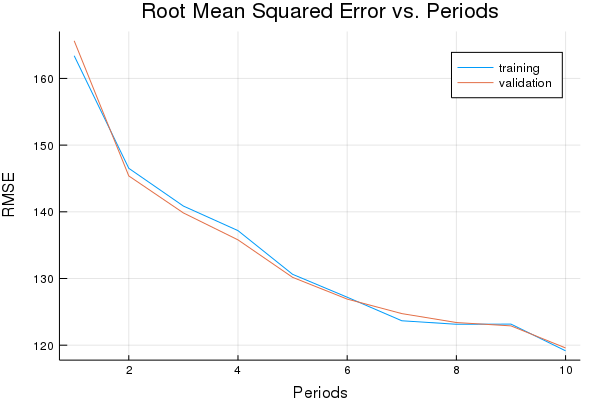

In [11]:
plot(p1)

## One-Hot Encoding for Discrete Features

Discrete (i.e. strings, enumerations, integers) features are usually converted into families of binary features before training a logistic regression model.

For example, suppose we created a synthetic feature that can take any of the values `0`, `1` or `2`, and that we have a few training points:

| # | feature_value |
|---|---------------|
| 0 |             2 |
| 1 |             0 |
| 2 |             1 |

For each possible categorical value, we make a new **binary** feature of **real values** that can take one of just two possible values: 1.0 if the example has that value, and 0.0 if not. In the example above, the categorical feature would be converted into three features, and the training points now look like:

| # | feature_value_0 | feature_value_1 | feature_value_2 |
|---|-----------------|-----------------|-----------------|
| 0 |             0.0 |             0.0 |             1.0 |
| 1 |             1.0 |             0.0 |             0.0 |
| 2 |             0.0 |             1.0 |             0.0 |

## Bucketized (Binned) Features

Bucketization is also known as binning.

We can bucketize `population` into the following 3 buckets (for instance):
- `bucket_0` (`< 5000`): corresponding to less populated blocks
- `bucket_1` (`5000 - 25000`): corresponding to mid populated blocks
- `bucket_2` (`> 25000`): corresponding to highly populated blocks

Given the preceding bucket definitions, the following `population` vector:

    [[10001], [42004], [2500], [18000]]

becomes the following bucketized feature vector:

    [[1], [2], [0], [1]]

The feature values are now the bucket indices. Note that these indices are considered to be discrete features. Typically, these will be further converted in one-hot representations as above, but this is done transparently.

The following code defines bucketized feature columns for `households` and `longitude`; the `get_quantile_based_boundaries` function calculates boundaries based on quantiles, so that each bucket contains an equal number of elements.

In [12]:
function get_quantile_based_boundaries(feature_values, num_buckets)
  #Investigate why [:] is necessary - there is some conflict that construct_feature_columns
  # spits out Array{Float64,2} where it should be Array{Float64,1}!!
  quantiles = StatsBase.nquantile(construct_feature_columns(feature_values)[:], num_buckets)
  return quantiles# [quantiles[q] for q in keys(quantiles)]
end

get_quantile_based_boundaries (generic function with 1 method)

In [13]:
function construct_bucketized_column(input_features, boundaries)
    
    data_out=zeros(size(input_features))
    
    for i=1:size(input_features,2)
       curr_feature=input_features[:,i]
       curr_boundary=boundaries[i]
        
        for k=1:length(curr_boundary)
        for j=1:size(input_features,1)
            if(curr_feature[j] >= curr_boundary[k] )
                data_out[j,i]+=1
            end
        end
        end

    end
    return data_out   
end

construct_bucketized_column (generic function with 1 method)

We need a special function to convert the bucketized columns into a one-hot encoding. Contrary to the high-level API of Python's TensorFlow, the Julia verion does not transparently handle buckets.

In [14]:
function construct_bucketized_onehot_column(input_features, boundaries)
    
    length_out=0
    for i=1:length(boundaries)
        length_out+=length(boundaries[i])-1
    end
    
    data_out=zeros(size(input_features,1), length_out)
    
    curr_index=1;
    for i=1:size(input_features,2)
       curr_feature=input_features[:,i]
       curr_boundary=boundaries[i]
        
        for k=1:length(curr_boundary)-1
        for j=1:size(input_features,1)
            if((curr_feature[j] >= curr_boundary[k]) && (curr_feature[j] < curr_boundary[k+1] ))
                data_out[j,curr_index]+=1
            end
        end
            curr_index+=1;
        end
    end
    return data_out   
end

construct_bucketized_onehot_column (generic function with 1 method)

Let's divide the household and longitude data into buckets.

In [15]:
# Divide households into 7 buckets.
households = california_housing_dataframe[:households]
bucketized_households = construct_bucketized_onehot_column(
    households, [get_quantile_based_boundaries(
    california_housing_dataframe[:households], 7)])

# Divide longitude into 10 buckets.
longitude = california_housing_dataframe[:longitude]
bucketized_longitude  = construct_bucketized_onehot_column(
    longitude, [get_quantile_based_boundaries(
    california_housing_dataframe[:longitude], 10)])

17000×10 Array{Float64,2}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 ⋮                        ⋮                      
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.

## Task 1: Train the Model on Bucketized Feature Columns
**Bucketize all the real valued features in our example, train the model and see if the results improve.**

In the preceding code block, two real valued columns (namely `households` and `longitude`) have been transformed into bucketized feature columns. Your task is to bucketize the rest of the columns, then run the code to train the model. There are various heuristics to find the range of the buckets. This exercise uses a quantile-based technique, which chooses the bucket boundaries in such a way that each bucket has the same number of examples.

In [16]:
quantiles_latitude=get_quantile_based_boundaries(
    training_examples[:latitude], 10)
quantiles_longitude=get_quantile_based_boundaries(
    training_examples[:longitude], 10)
quantiles_housing_median_age=get_quantile_based_boundaries(
    training_examples[:housing_median_age], 7)
quantiles_households=get_quantile_based_boundaries(
    training_examples[:households], 7)
quantiles_median_income=get_quantile_based_boundaries(
    training_examples[:median_income], 7)
quantiles_rooms_per_person=get_quantile_based_boundaries(
    training_examples[:rooms_per_person], 7)

quantiles_vec=[quantiles_latitude,
               quantiles_longitude,
                quantiles_housing_median_age,
                quantiles_households,
                quantiles_median_income,
                quantiles_rooms_per_person 
]

6-element Array{Array{Float64,1},1}:
 [32.55, 33.61, 33.85, 33.99, 34.09, 34.24, 36.61, 37.48, 37.81, 38.48, 41.95]                    
 [-124.3, -122.29, -121.98, -121.34, -119.83, -118.48, -118.3, -118.12, -117.87, -117.24, -114.31]
 [1.0, 15.0, 20.0, 26.0, 32.0, 36.0, 43.0, 52.0]                                                  
 [1.0, 220.0, 300.0, 372.0, 453.0, 572.0, 773.0, 6082.0]                                          
 [0.4999, 2.12521, 2.6923, 3.234, 3.81649, 4.52643, 5.58403, 15.0001]                             
 [0.0180649, 1.24696, 1.59646, 1.84287, 2.03541, 2.23856, 2.5183, 52.0333]                        

In [17]:
weight, bias, p1 = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    0.03, #learning rate
    2000, #steps
    100, #batch_size
    x -> construct_bucketized_onehot_column(x, quantiles_vec), # feature column function
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 202.72463349839262
  period 2: 171.78849030380562
  period 3: 145.2635554495821
  period 4: 124.71823709982627
  period 5: 110.32950574255553
  period 6: 100.6139387049533
  period 7: 93.60621652368602
  period 8: 88.30830153898088
  period 9: 84.12833254564481
  period 10: 80.90929566707702
Model training finished.
Final RMSE (on training data): 80.90929566707702
Final Weight (on training data): [39.3923; 43.1646; 22.9269; 44.9485; 45.9324; 10.1383; 39.0275; 49.2261; 15.8903; -27.9299; 50.2951; 43.2011; 26.3118; -11.8351; 17.9301; 58.4617; 32.1206; 34.3472; 21.7817; -6.78351; 19.5952; 23.5582; 32.8533; 30.6326; 30.7012; 31.973; 31.6763; 31.1743; 31.591; 31.1047; 34.6392; 35.6798; 38.3245; 41.5214; -31.3323; -17.3332; 2.60318; 15.4069; 29.15; 45.0948; 65.9498; -7.01649; -5.40451; 4.29645; 16.067; 33.9617; 49.9225; 61.5666]
Final Bias (on training data): 49.640670673368234


([39.3923; 43.1646; … ; 49.9225; 61.5666], 49.640670673368234, Plot{Plots.GRBackend() n=2})

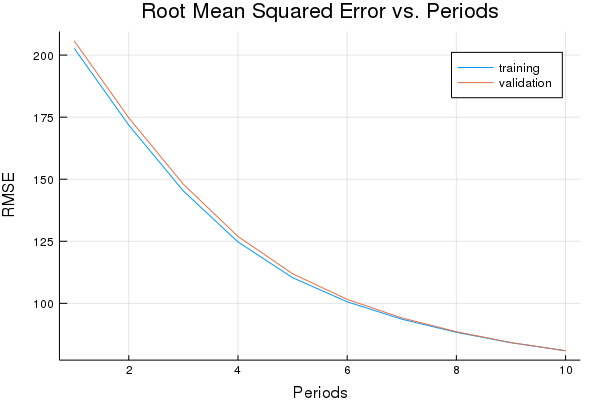

In [18]:
plot(p1)

## Feature Crosses

Crossing two (or more) features is a clever way to learn non-linear relations using a linear model. In our problem, if we just use the feature `latitude` for learning, the model might learn that city blocks at a particular latitude (or within a particular range of latitudes since we have bucketized it) are more likely to be expensive than others. Similarly for the feature `longitude`. However, if we cross `longitude` by `latitude`, the crossed feature represents a well defined city block. If the model learns that certain city blocks (within range of latitudes and longitudes) are more likely to be more expensive than others, it is a stronger signal than two features considered individually.

If we cross the `latitude` and `longitude` features (supposing, for example, that `longitude` was bucketized into `2` buckets, while `latitude` has `3` buckets), we actually get six crossed binary features. Each of these features will get its own separate weight when we train the model.

## Task 2: Train the Model Using Feature Crosses

**Add a feature cross of `longitude` and `latitude` to your model, train it, and determine whether the results improve.**

The following function creates a feature cross of latitude and longitude and then feeds it to the model.

In [19]:
function construct_latXlong_onehot_column(input_features, boundaries) 
    #latitude and longitude are the first two columns - treat them separately
    
    #initialization - calculate total length of feature_vec
    length_out=0
    # lat and long
    length_lat=length(boundaries[1])-1
    length_long= length(boundaries[2])-1
    length_out+=length_lat*length_long
    # all other features
    for i=3:length(boundaries)
        length_out+=length(boundaries[i])-1
    end
    data_out=zeros(size(input_features,1), length_out)
      
    # all other features
    curr_index=length_lat*length_long+1;
    for i=3:size(input_features,2)
        curr_feature=input_features[:,i]
       curr_boundary=boundaries[i]
       #println(curr_boundary)
        
        for k=1:length(curr_boundary)-1
        for j=1:size(input_features,1)
            if((curr_feature[j] >= curr_boundary[k]) && (curr_feature[j] < curr_boundary[k+1] ))
                data_out[j,curr_index]+=1
            end
        end
            curr_index+=1;
        end
    end
    
    # lat and long
    data_temp=zeros(size(input_features,1), length_lat+length_long)
    curr_index=1
        for i=1:2
        curr_feature=input_features[:,i]
       curr_boundary=boundaries[i]
       #println(curr_boundary)
        
        for k=1:length(curr_boundary)-1
        for j=1:size(input_features,1)
            if((curr_feature[j] >= curr_boundary[k]) && (curr_feature[j] < curr_boundary[k+1] ))
                data_temp[j,curr_index]+=1
            end
        end
            curr_index+=1;
        end
    end
    
    vec_temp=1
    for j=1:size(input_features,1)
        vec1=data_temp[j,1:length_lat]
        vec2=data_temp[j, length_lat+1:length_lat+length_long]
        vec_temp=vec1*vec2'
        data_out[j, 1:length_lat*length_long]= (vec_temp)[:]
    end
    
    return data_out 
end

construct_latXlong_onehot_column (generic function with 1 method)

In [20]:
weight, bias, p1 = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    0.03, #learning rate
    2000, #steps
    100, #batch_size
    x -> construct_latXlong_onehot_column(x, quantiles_vec), # feature column function
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 208.01934398715014
  period 2: 181.32512572835964
  period 3: 157.3466935603145
  period 4: 136.90056422790624
  period 5: 120.48339242694792
  period 6: 108.01996714153945
  period 7: 98.69501405105021
  period 8: 91.59963480335907
  period 9: 86.0126149075253
  period 10: 81.53319732851088
Model training finished.
Final RMSE (on training data): 81.53319732851088
Final Weight (on training data): [0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 10.781; 61.097; 33.9225; -24.2297; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 56.053; 27.9595; 34.8299; -26.6627; 0.0; 0.0; 0.0; 0.0; 0.0; 30.0389; 45.3963; 33.0454; 3.48417; -26.6781; 0.0; 0.0; 0.0; 0.0; 0.0; 16.2348; -30.6454; -9.64208; -22.339; -11.2892; 0.0; 0.0; 9.26873; 37.3225; 43.7293; 10.2209; -37.8064; -1.9528; -4.64414; 0.0; 13.061; 44.5835; 44.2813; 56.928; 49.7988; 13.144; -6.29884; -3.23325; 0.0; 0.0; 0.0; 38.3727; 4.61048; 27.0774; 45.9326; 7.20543; -4.86048; 0.0; 0.0; 0.0; 6.3926; 41.4644; 29.9347; 23.31; 

([0.0; 0.0; … ; 52.3533; 61.9954], 55.103583663594556, Plot{Plots.GRBackend() n=2})

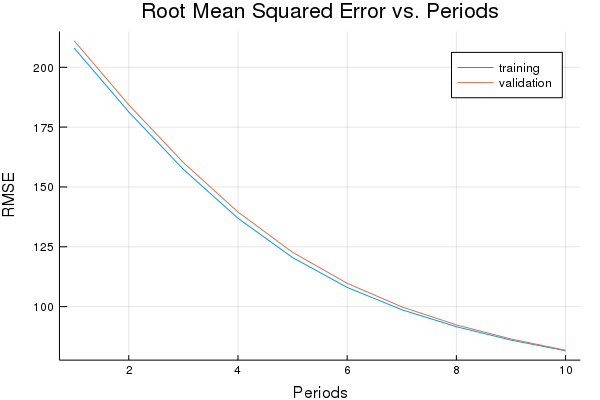

In [21]:
plot(p1)

## Optional Challenge: Try Out More Synthetic Features

So far, we've tried simple bucketized columns and feature crosses, but there are many more combinations that could potentially improve the results. For example, you could cross multiple columns. What happens if you vary the number of buckets? What other synthetic features can you think of? Do they improve the model?